In [1]:
import numpy     as  np

import f_shadow  as sh
import f_fermi   as fm
import f_molchem as cm

import os
import matplotlib.pyplot as plt

from openfermion.ops.operators import FermionOperator
from openfermion.transforms import get_fermion_operator
from openfermion.chem       import MolecularData
from openfermion.linalg     import get_ground_state, get_sparse_operator, get_number_preserving_sparse_operator
from openfermionpyscf       import run_pyscf

In [2]:
np.set_printoptions(precision=4,suppress=True)
np.set_printoptions(linewidth=np.inf)

In [33]:
# Set molecule parameters.
basis = 'sto-6g'
multiplicity = 1

# Set calculation parameters.
run_scf  = 1
run_mp2  = 1
run_cisd = 0
run_ccsd = 0
run_fci  = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
fermion_energies = []
bond_lengths = []

#we assume Li-H molecule
ll = 8
L0 = range(ll)

nn = 4 

Op2, Op4 	= fm.Fermi_op(ll,nn)

# RECONSTRUCTION

vec_scale = [1,4,10,20]
vec_meas  = [-1]
vec_unit  = [100]

In [34]:
data = []            

for bond_length in np.linspace(0.5, 2.5, num=20):

    geometry = [('H', (0., 0., -bond_length)), ('H', (0., 0., 0.)), ('H', (0., 0., bond_length)), ('H', (0., 0., 2*bond_length))]
    molecule = MolecularData(geometry, basis, multiplicity, description=str(round(bond_length, 2)))

    # Run pyscf.
    molecule = run_pyscf(molecule,
                         run_scf=run_scf,
                         run_mp2=run_mp2,
                         run_cisd=run_cisd,
                         run_ccsd=run_ccsd,
                         run_fci=run_fci)

    molecular_hamiltonian = molecule.get_molecular_hamiltonian()

    fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
    fermion_hamiltonian.compress()
    sparse_hamiltonian  = get_number_preserving_sparse_operator(fermion_hamiltonian, num_qubits=ll, num_electrons=nn)
    E_0, psi            = get_ground_state(sparse_hamiltonian)
    psih                = np.conjugate(psi)    

###### hamiltonian creation and check
    E0, H2, H4  = cm.ham_coef(molecular_hamiltonian)

##### GS energy, 1st state, kinetic, potential, psi, ham 
    cor_2   = np.array([[   np.einsum( 'x,xy,y',  psih, Op2[i][j].todense(), psi, optimize=True) for i in L0] for j in L0])
    cor_4   = np.array([[[[ np.einsum( 'x,xy,y',  psih, Op4[i][j][k][l].todense(), psi, optimize=True)   for i in L0] for j in L0] for k in L0] for l in L0])

    KK = cm.RECO_chem_K(H2,cor_2)
    VV = cm.RECO_chem_V(H4,cor_4)
    
    # RECONSTRUCTION
    
    for scale in vec_scale:

        for n_M in vec_meas:

            NU  = np.max(vec_unit) 
            ene = sh.shad_en(cor_2, cor_4, ll*scale, NU, n_M, H2, H4)                    

            for n_U in vec_unit:

                EE = ene[:n_U].reshape(n_U,2).T
                EE2 = EE[0]
                EE4 = EE[1]

                MME_2 = np.mean(EE2)
                SSE_2 = np.std (EE2)

                MME_4 = np.mean(EE4)
                SSE_4 = np.std (EE4)

                E_tot = E0+MME_2+MME_4
                DE_tot = np.std(EE2+EE4)

                data.append([bond_length, scale, n_M, n_U, E_0, E_tot, DE_tot, E0])

                [bond_length, scale, n_M, n_U, E_0, E_tot, DE_tot, E0]

data = np.array(data) 

In [35]:
data1 = data[data[:,1]==vec_scale[0]]
data2 = data[data[:,1]==vec_scale[1]]
data3 = data[data[:,1]==vec_scale[2]]
data4 = data[data[:,1]==vec_scale[3]]

In [36]:
R = data1[:,0]
E_ex  = data1[:,4]

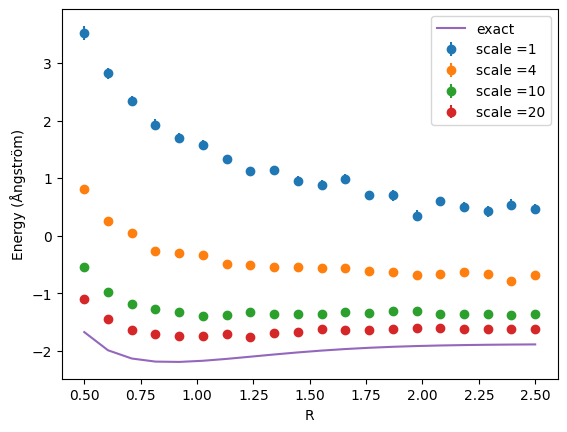

In [38]:
# We plot the first line of the reconstructed one body density matrix

x  = R

y  = data1[:,5]
dy = data1[:,6]/np.sqrt(data1[:,3])

plt.errorbar(x, y, yerr=dy, marker='o', linestyle='None', label='scale ='+str(vec_scale[0]));

y  = data2[:,5]
dy = data2[:,6]/np.sqrt(data2[:,3])

plt.errorbar(x, y, yerr=dy, marker='o', linestyle='None', label='scale ='+str(vec_scale[1]));

y  = data3[:,5]
dy = data3[:,6]/np.sqrt(data3[:,3])

plt.errorbar(x, y, yerr=dy, marker='o', linestyle='None', label='scale ='+str(vec_scale[2]));

y  = data4[:,5]
dy = data4[:,6]/np.sqrt(data4[:,3])

plt.errorbar(x, y, yerr=dy, marker='o', linestyle='None', label='scale ='+str(vec_scale[3]));


real_y = E_ex
plt.plot(x, real_y, label='exact')

plt.xlabel("R")
plt.ylabel("Energy (Ångström)")

plt.legend()